In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau

df = pd.read_parquet('../data/processed/preprocessed_data_with_embeddings_and_ohe.parquet')

# The model a "Neural Collaborative Filtering" (NCF) model. 
# It is designed for collaborative filtering tasks,  where it leverages neural networks to learn user and item embeddings and combines them to predict user-item ratings

In [2]:
# Prepare the feature matrix and target vector
X = df.drop(columns=['rating'])
y = df['rating']

# Create mappings for userId and movieId to continuous indices
user_mapping = {user_id: idx for idx, user_id in enumerate(X['userId'].unique())}
movie_mapping = {movie_id: idx for idx, movie_id in enumerate(X['movieId'].unique())}

# Map userId and movieId to continuous indices
X['userId'] = X['userId'].map(user_mapping)
X['movieId'] = X['movieId'].map(movie_mapping)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Get the number of unique users and items
num_users = len(user_mapping)
num_items = len(movie_mapping)

In [3]:
# Define the NCF model
embedding_dim = 20  # Reduced embedding dimension
regularization = l2(0.001)  # L2 regularization factor

user_input = Input(shape=(1,), name='user_input')
item_input = Input(shape=(1,), name='item_input')

user_embedding = Embedding(input_dim=num_users, output_dim=embedding_dim, name='user_embedding', embeddings_regularizer=regularization)(user_input)
item_embedding = Embedding(input_dim=num_items, output_dim=embedding_dim, name='item_embedding', embeddings_regularizer=regularization)(item_input)

user_flat = Flatten()(user_embedding)
item_flat = Flatten()(item_embedding)

concat = Concatenate()([user_flat, item_flat])

fc1 = Dense(64, activation='relu')(concat)  # Reduced size of dense layers
drop1 = Dropout(0.2)(fc1)  # Reduced dropout rate
fc2 = Dense(32, activation='relu')(drop1)
drop2 = Dropout(0.2)(fc2)
fc3 = Dense(16, activation='relu')(drop2)
output = Dense(1)(fc3)

# Use MAE as metric
model = Model(inputs=[user_input, item_input], outputs=output)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mae')

# Prepare the inputs
train_user_input = X_train['userId']
train_item_input = X_train['movieId']
test_user_input = X_test['userId']
test_item_input = X_test['movieId']

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)


In [4]:
# Train the model
history = model.fit([train_user_input, train_item_input], y_train,
                    epochs=30, batch_size=256, validation_split=0.1, verbose=1, callbacks=[reduce_lr])

# Evaluate the model
y_pred = model.predict([test_user_input, test_item_input])
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'RMSE: {rmse:.4f}')

Epoch 1/30
13900/13900 ━━━━━━━━━━━━━━━━━━━━ 1860s 134ms/step - loss: 0.9286 - val_loss: 0.7759 - learning_rate: 0.0010
Epoch 2/30
13900/13900 ━━━━━━━━━━━━━━━━━━━━ 732s 52ms/step - loss: 0.7767 - val_loss: 0.7747 - learning_rate: 0.0010
Epoch 3/30
13900/13900 ━━━━━━━━━━━━━━━━━━━━ 431s 31ms/step - loss: 0.7765 - val_loss: 0.7840 - learning_rate: 0.0010
Epoch 4/30
13900/13900 ━━━━━━━━━━━━━━━━━━━━ 431s 31ms/step - loss: 0.7810 - val_loss: 0.7766 - learning_rate: 0.0010
Epoch 5/30
13900/13900 ━━━━━━━━━━━━━━━━━━━━ 433s 31ms/step - loss: 0.7773 - val_loss: 0.7799 - learning_rate: 0.0010
Epoch 6/30
13900/13900 ━━━━━━━━━━━━━━━━━━━━ 432s 31ms/step - loss: 0.7393 - val_loss: 0.7123 - learning_rate: 2.0000e-04
Epoch 7/30
13900/13900 ━━━━━━━━━━━━━━━━━━━━ 432s 31ms/step - loss: 0.7054 - val_loss: 0.7051 - learning_rate: 2.0000e-04
Epoch 8/30
13900/13900 ━━━━━━━━━━━━━━━━━━━━ 433s 31ms/step - loss: 0.6995 - val_loss: 0.7046 - learning_rate: 2.0000e-04
Epoch 9/30
13900/13900 ━━━━━━━━━━━━━━━━━━━━ 434s 3

c:\Users\Leo\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [5]:
from keras.models import load_model

# Save the model
model.save('../models/ncf_model.keras')

# Later, to load the model
#loaded_model = load_model('../models/ncf_model.keras')


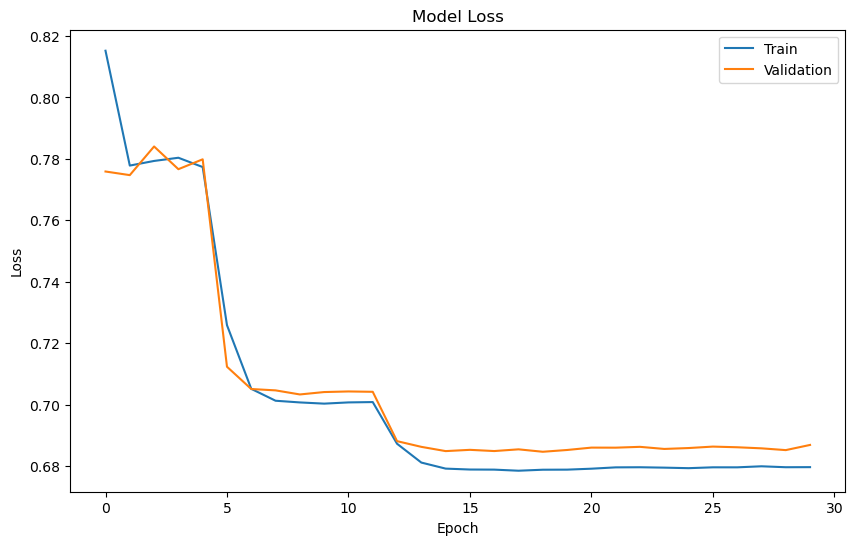

In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


In [8]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, f1_score, precision_score

# Evaluate the model
y_pred = model.predict([test_user_input, test_item_input])

# Convert predictions to binary by setting a threshold (e.g., 3.5)
threshold = 3.5
y_test_binary = (y_test >= threshold).astype(int)
y_pred_binary = (y_pred >= threshold).astype(int)

# Calculate regression metrics
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Calculate classification metrics
accuracy = accuracy_score(y_test_binary, y_pred_binary)
f1 = f1_score(y_test_binary, y_pred_binary, average='weighted')
precision = precision_score(y_test_binary, y_pred_binary, average='weighted')

# Create a DataFrame to display the metrics
metrics_df = pd.DataFrame({
    'Metric': ['RMSE', 'MAE', 'R^2 Score', 'Accuracy', 'F1 Score', 'Precision'],
    'Value': [rmse, mae, r2, accuracy, f1, precision]
})

# Print the metrics table
print(metrics_df)


41185/41185 ━━━━━━━━━━━━━━━━━━━━ 43s 1ms/step


c:\Users\Leo\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


      Metric     Value
0       RMSE  0.924392
1        MAE  0.674445
2  R^2 Score  0.236131
3   Accuracy  0.714448
4   F1 Score  0.710167
5  Precision  0.710351


In [9]:
import joblib

joblib.dump(metrics_df, "../models/Metrics_NCF_DL.pkl")

['../models/Metrics_NCF_DL.pkl']

In [10]:
joblib.load("../models/Metrics_NCF_DL.pkl")

,Metric,Value
0,RMSE,0.924392
1,MAE,0.674445
2,R^2 Score,0.236131
3,Accuracy,0.714448
4,F1 Score,0.710167
5,Precision,0.710351
